In [43]:
from ultralytics import YOLO
import os
import torch
import glob
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.optim as optim
import plot
import distance_estimation
import utils
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
robot_height = 0.545 # m
torch.manual_seed(0)

In [45]:
ROOT = './csv_data/Spherical_Coordinate/with_predictions/dist2_uvwh_spherical_set1/'
path_dir = os.listdir(ROOT)
path_dir

['corridor_set1_df.csv',
 'corridor_set2_df.csv',
 'first_floor_day1_set1_df.csv',
 'first_floor_day1_set2_df.csv',
 'first_floor_day2_set1_df.csv',
 'first_floor_day2_set2_df.csv',
 'first_floor_straight.csv']

In [46]:
corridor_set1_df = pd.read_csv(ROOT + path_dir[0], sep = ',')
corridor_set2_df = pd.read_csv(ROOT + path_dir[1], sep = ',')
first_floor_day1_set1_df = pd.read_csv(ROOT + path_dir[2], sep = ',')
first_floor_day1_set2_df = pd.read_csv(ROOT + path_dir[3], sep = ',')
first_floor_day2_set1_df = pd.read_csv(ROOT + path_dir[4], sep = ',')
first_floor_day2_set2_df = pd.read_csv(ROOT + path_dir[5], sep = ',')
first_floor_straight = pd.read_csv(ROOT + path_dir[6], sep = ',')

In [47]:
first_floor_day1_set1_df

,Unnamed: 0,filename,gt_x,gt_y,gt_heading,x1,y1,x2,y2,X1,...,angle,u,v,w,h,angle_pred,dist_pred,angle_error,coming,going
0,0,1708418097.194988_F.jpg,1.08000,0.160000,0.034907,1354.5,1583.6,1602.4,1927.2,-0.108961,...,1.717875,0.513351,0.609514,0.086076,0.119306,1.599827,0.964821,0.000000,0,0
1,1,1708418098.197396_F.jpg,1.08000,0.160000,0.034907,1354.4,1583.5,1602.6,1927.1,-0.109083,...,1.717875,0.513368,0.609479,0.086181,0.119306,1.599820,0.964821,0.000000,0,0
2,2,1708418099.236570_F.jpg,1.08000,0.160000,0.034907,1354.5,1583.8,1602.2,1926.9,-0.108958,...,1.717875,0.513316,0.609497,0.086007,0.119132,1.599994,0.964821,0.000000,0,0
3,3,1708418100.374095_F.jpg,1.15692,0.173431,0.032638,1354.5,1583.6,1602.3,1926.9,-0.108961,...,1.719596,0.513333,0.609462,0.086042,0.119201,1.599912,0.964821,0.119684,0,1
4,4,1708418101.192885_F.jpg,1.29152,0.189010,0.035605,1354.8,1583.4,1601.7,1927.5,-0.108599,...,1.716112,0.513281,0.609531,0.085729,0.119479,1.599762,0.964821,-0.116350,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,366,1708418579.225012_F.jpg,1.26218,0.307585,0.189194,1309.0,1583.7,1545.9,1907.2,-0.163899,...,1.809831,0.495642,0.606059,0.082257,0.112326,1.652363,0.973641,0.000000,0,0
367,367,1708418580.351988_F.jpg,1.26218,0.307585,0.189194,1309.5,1582.3,1545.9,1906.8,-0.163323,...,1.809831,0.495729,0.605746,0.082083,0.112674,1.651757,0.970101,0.000000,0,0
368,368,1708418581.178134_F.jpg,1.26218,0.307585,0.189194,1309.4,1582.1,1544.9,1906.4,-0.163447,...,1.809831,0.495538,0.605642,0.081771,0.112604,1.652152,0.973767,0.000000,0,0
369,369,1708418582.173971_F.jpg,1.26218,0.307585,0.189194,1309.3,1581.9,1544.6,1905.3,-0.163571,...,1.809831,0.495469,0.605417,0.081701,0.112292,1.652443,0.977752,0.000000,0,0


In [49]:
class distance_error_removal(nn.Module):
    def __init__(self):
        super(distance_error_removal, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [50]:
set1 = pd.concat([corridor_set1_df, first_floor_day1_set1_df, first_floor_day2_set1_df])
set2 = pd.concat([corridor_set2_df, first_floor_day1_set2_df, first_floor_day2_set2_df, first_floor_straight])

In [51]:
x_data = torch.tensor(set2[['coming','going','angle_pred','dist_pred']].values, dtype=torch.float32).to(device).reshape(-1, 4)
y_data = torch.tensor(set2[['angle_error']].values, dtype=torch.float32).to(device).reshape(-1, 1)
# torch.tensor(train_df[['angle']].values, dtype=torch.float32).to(device).reshape(-1, 1)
# torch.tensor(train_df[['abs_dist']].values, dtype=torch.float32).to(device).reshape(-1, 1)

x_test = torch.tensor(set1[['coming','going','angle_pred','dist_pred']].values, dtype=torch.float32).to(device).reshape(-1, 4)
y_test = torch.tensor(set1[['angle_error']].values, dtype=torch.float32).to(device).reshape(-1, 1)

In [52]:
# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
# Create a DataLoader with shuffle=True
train_dataset = TensorDataset(x_data, y_data)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [53]:
torch.manual_seed(0)
model = distance_error_removal()
# model.load_state_dict(torch.load('./models/Angle1_THE_BEST.pth'))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.MSELoss()
# loss_fn = Loss(model, l1_strength=0.001, l2_strength=0.001)
# loss_fn.to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [54]:
#check out the parameters
list(model.parameters())

epochs = 1000

#track different values
epoch_count = []
train_loss_values = []
val_loss_values = []
mae_values = []    # mean absolute error
best_loss = float('inf')

for epoch in range(epochs):
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        #set the model to training mode
        model.train()
        # # 1. Forward pass
        y_pred = model(x_train)

        loss = loss_fn(y_pred, y_train)

        # # print(y_pred)
        # # print(y_train)
        # # 2. Calculate the loss
        # loss = loss_fn(y_pred, y_train)
        # #print(f"Loss after {epoch+1} epochs: {loss}")

        # # 3. Optimizer zero grad
        # optimizer.zero_grad()
        # Inside your training loop
        optimizer.zero_grad()

        # 4. Perform backpropagation on the loss with respect to the parameters of the model
        loss.backward()  # calculate gradients

        # 5. Step the optimizer (perform gradient descent)
        optimizer.step() # update model parameters        by default how the optimizer changes will accumulate through the loop so.. we have to zero them above in step 3

    model.eval() # turn off gradient tracking

    with torch.inference_mode():
        val_pred = model(x_test)
        val_loss = loss_fn(val_pred, y_test)
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        val_loss_values.append(val_loss)
        # Calculate mean absolute error
        mae = torch.mean(torch.abs(val_pred - y_test))
        mae_values.append(mae.item())
        std_error = torch.std(torch.abs(val_pred - y_test))

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if epoch%500==0:
        torch.save(model.state_dict(), f'epoch_{epoch}_model.pth')

    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {val_loss} | MAE: {mae} | Std: {std_error}")

# print(model.state_dict())

Epoch: 0 | Loss: 0.008176720701158047 | Test loss: 0.022404437884688377 | MAE: 0.10442803055047989 | Std: 0.10727982223033905
Epoch: 10 | Loss: 0.001963090617209673 | Test loss: 0.01953267864882946 | MAE: 0.09630103409290314 | Std: 0.10132855176925659
Epoch: 20 | Loss: 0.014181334525346756 | Test loss: 0.018597489222884178 | MAE: 0.09361417591571808 | Std: 0.09920787066221237
Epoch: 30 | Loss: 0.018467525020241737 | Test loss: 0.01811891794204712 | MAE: 0.08880958706140518 | Std: 0.10119505226612091
Epoch: 40 | Loss: 0.007954541593790054 | Test loss: 0.019823860377073288 | MAE: 0.09746234863996506 | Std: 0.1016547754406929
Epoch: 50 | Loss: 0.005325566977262497 | Test loss: 0.0190160870552063 | MAE: 0.09297004342079163 | Std: 0.10188936442136765
Epoch: 60 | Loss: 0.03785393759608269 | Test loss: 0.018188340589404106 | MAE: 0.0887426882982254 | Std: 0.10159629583358765
Epoch: 70 | Loss: 0.06350358575582504 | Test loss: 0.017638104036450386 | MAE: 0.08748612552881241 | Std: 0.09996367245

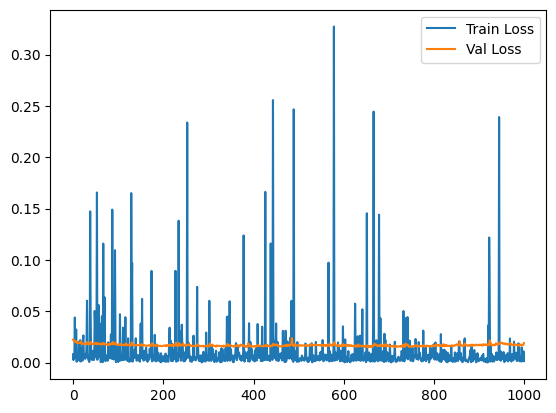

In [55]:
plt.plot(epoch_count, torch.tensor(train_loss_values).numpy(), label='Train Loss')
plt.plot(epoch_count, torch.tensor(val_loss_values).numpy(), label='Val Loss')
plt.legend(['Train Loss', 'Val Loss']) 